<a href="https://colab.research.google.com/github/babi2707/Trabalho-PAI---Reconhecimento-Papanicolau/blob/etapa2/algoritmo/backend/Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install joblib

In [9]:
# Célula 1:
import zipfile

caminho_pasta_compactada = '/content/sub_images.zip'
caminho_destino = '/content/sub_images'

with zipfile.ZipFile(caminho_pasta_compactada, 'r') as zip_ref:
    zip_ref.extractall(caminho_destino)

In [10]:
# Célula 2:
import os

base_dir = '/content/sub_images/sub_images'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']
for class_name in classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

In [11]:
#Célula 3:
from sklearn.model_selection import train_test_split
import os
import numpy as np

# Diretório onde estão os dados
data_dir = '/content/sub_images/sub_images'

# Lista para armazenar os nomes dos arquivos e suas respectivas classes
file_names = []
labels = []

# Preencher as listas com os nomes dos arquivos e suas classes correspondentes
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        file_names.append(file_path)
        labels.append(class_name)

# Dividir os dados em treino e teste mantendo a proporção de 4:1
train_files = []
test_files = []
train_labels = []
test_labels = []

# Para cada classe, dividir os arquivos em treino e teste mantendo a proporção de 4:1
for class_name in set(labels):
    class_files = [file for file, label in zip(file_names, labels) if label == class_name]
    class_labels = [label for label in labels if label == class_name]

    # Dividir os arquivos e rótulos em treino e teste
    class_train_files, class_test_files, class_train_labels, class_test_labels = train_test_split(
        class_files, class_labels, test_size=0.2, random_state=42)

    # Adicionar os arquivos e rótulos aos conjuntos de treino e teste
    train_files.extend(class_train_files)
    test_files.extend(class_test_files)
    train_labels.extend(class_train_labels)
    test_labels.extend(class_test_labels)

# Verificar o balanceamento das classes nos conjuntos de treino e teste
unique, counts = np.unique(train_labels, return_counts=True)
print(f'Balanceamento das classes no conjunto de treino:')
for class_name, count in zip(unique, counts):
    print(f'Classe {class_name}: {count} amostras')

unique, counts = np.unique(test_labels, return_counts=True)
print(f'Balanceamento das classes no conjunto de teste:')
for class_name, count in zip(unique, counts):
    print(f'Classe {class_name}: {count} amostras')

Balanceamento das classes no conjunto de treino:
Classe ASC-H: 67 amostras
Classe ASC-US: 312 amostras
Classe HSIL: 229 amostras
Classe LSIL: 394 amostras
Classe Negative for intraepithelial lesion: 800 amostras
Classe SCC: 65 amostras
Balanceamento das classes no conjunto de teste:
Classe ASC-H: 17 amostras
Classe ASC-US: 79 amostras
Classe HSIL: 58 amostras
Classe LSIL: 99 amostras
Classe Negative for intraepithelial lesion: 200 amostras
Classe SCC: 17 amostras


In [12]:
#Célula 4:
import shutil
import random
import os

def split_data(source_dir, train_dir, test_dir):
    for class_name in classes:
        class_dir = os.path.join(source_dir, class_name)
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)

        for image in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image)
            if image_path in train_files:
                dest_path = os.path.join(train_class_dir, image)
                if not os.path.exists(dest_path):
                    shutil.copy2(image_path, dest_path)
                else:
                    # Renomear o arquivo se já existir
                    base, ext = os.path.splitext(image)
                    new_dest_path = os.path.join(train_class_dir, f"{base}_copy{ext}")
                    shutil.copy2(image_path, new_dest_path)
            elif image_path in test_files:
                dest_path = os.path.join(test_class_dir, image)
                if not os.path.exists(dest_path):
                    shutil.copy2(image_path, dest_path)
                else:
                    # Renomear o arquivo se já existir
                    base, ext = os.path.splitext(image)
                    new_dest_path = os.path.join(test_class_dir, f"{base}_copy{ext}")
                    shutil.copy2(image_path, new_dest_path)

split_data(base_dir, train_dir, test_dir)

In [13]:
# Célula 5.2 - SVM:
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC  # Importando a classe SVC
import joblib

def extract_histogram_features(image_path, h_bins=16, s_bins=8):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1], None, [h_bins, s_bins], [0, 180, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

train_features = []
train_labels_hist = []
test_features = []
test_labels_hist = []

for file_path, label in zip(train_files, train_labels):
    features = extract_histogram_features(file_path)
    train_features.append(features)
    train_labels_hist.append(label)

for file_path, label in zip(test_files, test_labels):
    features = extract_histogram_features(file_path)
    test_features.append(features)
    test_labels_hist.append(label)

train_features = np.array(train_features)
test_features = np.array(test_features)

# Codificar as classes
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_hist)
test_labels_encoded = label_encoder.transform(test_labels_hist)

# Padronizar as características
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

svm_model = SVC(kernel='linear')
svm_model.fit(train_features_scaled, train_labels_encoded)
joblib.dump(svm_model, '/content/modelo_svm.pkl')

['/content/modelo_svm.pkl']

In [14]:
#Célula 5.3 - Resnet50:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Parameters
img_height, img_width = 100, 100
batch_size = 32
num_classes = 6
class_names = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']

# Data augmentation
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen_val_test.flow_from_directory(
    test_dir,  # usando test_dir para validação neste exemplo
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Primeira fase de treinamento
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=30
)

# Fine-tuning
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=20
)

test_loss, test_acc = model.evaluate(test_generator)

# Salvar o modelo em um arquivo .h5
model.save('modelo_resnet50.h5')
print(f'Test accuracy: {test_acc}')

Found 3734 images belonging to 6 classes.
Found 940 images belonging to 6 classes.
Found 940 images belonging to 6 classes.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/30
117/117 [==============================] - 35s 174ms/step - loss: 12.1317 - accuracy: 0.2927 - val_loss: 9.3401 - val_accuracy: 0.1234
Epoch 2/30
117/117 [==============================] - 18s 152ms/step - loss: 7.6073 - accuracy: 0.3623 - val_loss: 6.2854 - val_accuracy: 0.4277
Epoch 3/30
117/117 [==============================] - 17s 146ms/step - loss: 5.4028 - accuracy: 0.4116 - val_loss: 4.8898 - val_accuracy: 0.4617
Epoch 4/30
117/117 [==============================] - 18s 156ms/step - loss: 4.3149 - accuracy: 0.4261 - val_loss: 4.1066 - val_accuracy: 0.4277
Epoch 5/30
117/117 [==============================] - 17s 142ms/step - loss: 3.7718 - accuracy: 0.4339 - val_loss: 5.1989 - val_accuracy: 0.4234
Epoch 6/30
117/117 [==============================] - 19s 165ms/step - loss: 3.4506 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test accuracy: 0.6170212626457214


In [15]:
# Célula 6.2 - SVM:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Classificador binário (classe negativa X demais)
binary_labels_train = np.where(train_labels_encoded == 4, 0, 1)  # 'Negative for intraepithelial lesion' = 4
binary_labels_test = np.where(test_labels_encoded == 4, 0, 1)

svm_binary = SVC(kernel='linear')
svm_binary.fit(train_features_scaled, binary_labels_train)
binary_predictions = svm_binary.predict(test_features_scaled)

# Classificador multiclasse (6 classes)
svm_multiclass = SVC(kernel='linear')
svm_multiclass.fit(train_features_scaled, train_labels_encoded)
multiclass_predictions = svm_multiclass.predict(test_features_scaled)

# Avaliação do classificador binário
binary_accuracy = accuracy_score(binary_labels_test, binary_predictions)
binary_conf_matrix = confusion_matrix(binary_labels_test, binary_predictions)
print('Binary Classifier Accuracy:', binary_accuracy)
print('Binary Classifier Confusion Matrix:')
print(binary_conf_matrix)
print('Binary Classifier Classification Report:')
print(classification_report(binary_labels_test, binary_predictions, target_names=['Negative', 'Others']))

# Avaliação do classificador multiclasse
multiclass_accuracy = accuracy_score(test_labels_encoded, multiclass_predictions)
multiclass_conf_matrix = confusion_matrix(test_labels_encoded, multiclass_predictions)
print('Multiclass Classifier Accuracy:', multiclass_accuracy)
print('Multiclass Classifier Confusion Matrix:')
print(multiclass_conf_matrix)
print('Multiclass Classifier Classification Report:')
print(classification_report(test_labels_encoded, multiclass_predictions, target_names=label_encoder.classes_))

Binary Classifier Accuracy: 0.7148936170212766
Binary Classifier Confusion Matrix:
[[154  46]
 [ 88 182]]
Binary Classifier Classification Report:
              precision    recall  f1-score   support

    Negative       0.64      0.77      0.70       200
      Others       0.80      0.67      0.73       270

    accuracy                           0.71       470
   macro avg       0.72      0.72      0.71       470
weighted avg       0.73      0.71      0.72       470

Multiclass Classifier Accuracy: 0.5468085106382978
Multiclass Classifier Confusion Matrix:
[[  6   4   4   1   2   0]
 [  7  18   6  10  38   0]
 [  0   6  33   7   6   6]
 [  2   6   9  23  56   3]
 [  0  12   3  10 175   0]
 [  0   5   6   2   2   2]]
Multiclass Classifier Classification Report:
                                     precision    recall  f1-score   support

                              ASC-H       0.40      0.35      0.38        17
                             ASC-US       0.35      0.23      0.28      

In [16]:
#Célula 6.3 - Resnet50:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Função para plotar gráfico de aprendizado
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Predict on test data
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Accuracy and classification report
accuracy = accuracy_score(true_classes, predicted_classes)

<ipython-input-16-b9b46edf0748>:29: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


30/30 [==============================] - 2s 39ms/step


 1/30 [>.............................] - ETA: 2s

<ipython-input-17-f7923f7bcb5e>:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


30/30 [==============================] - 1s 47ms/step
ResNet50 Classifier Accuracy: 0.28936170212765955
ResNet50 Classifier Confusion Matrix:
[[  0   1   4  12  15   2]
 [  2  17  13  38  84   4]
 [  3  12  12  30  55   4]
 [  1  14  27  45 100  11]
 [  4  33  66  86 198  13]
 [  0   1   4  11  18   0]]
ResNet50 Classifier Classification Report:
                                     precision    recall  f1-score   support

                              ASC-H       0.00      0.00      0.00        34
                             ASC-US       0.22      0.11      0.14       158
                               HSIL       0.10      0.10      0.10       116
                               LSIL       0.20      0.23      0.21       198
Negative for intraepithelial lesion       0.42      0.49      0.46       400
                                SCC       0.00      0.00      0.00        34

                           accuracy                           0.29       940
                          macro av

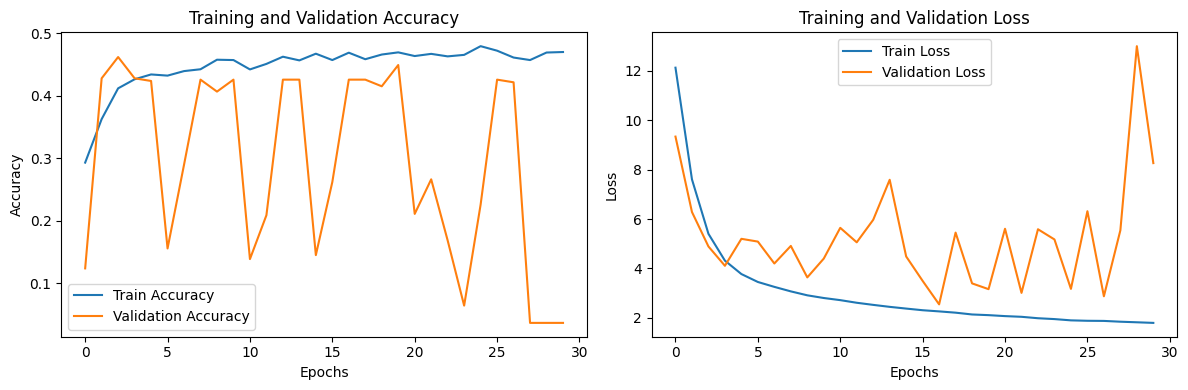

In [17]:
# Célula 7 - Comparação dos Resultados ResNet50

# Previsões no conjunto de teste
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Acurácia e relatório de classificação
accuracy = accuracy_score(true_classes, predicted_classes)
conf_matrix = confusion_matrix(true_classes, predicted_classes)
classification_report_resnet = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(f'ResNet50 Classifier Accuracy: {accuracy}')
print('ResNet50 Classifier Confusion Matrix:')
print(conf_matrix)
print('ResNet50 Classifier Classification Report:')
print(classification_report_resnet)

# Plotar curvas de aprendizado
plot_learning_curves(history)

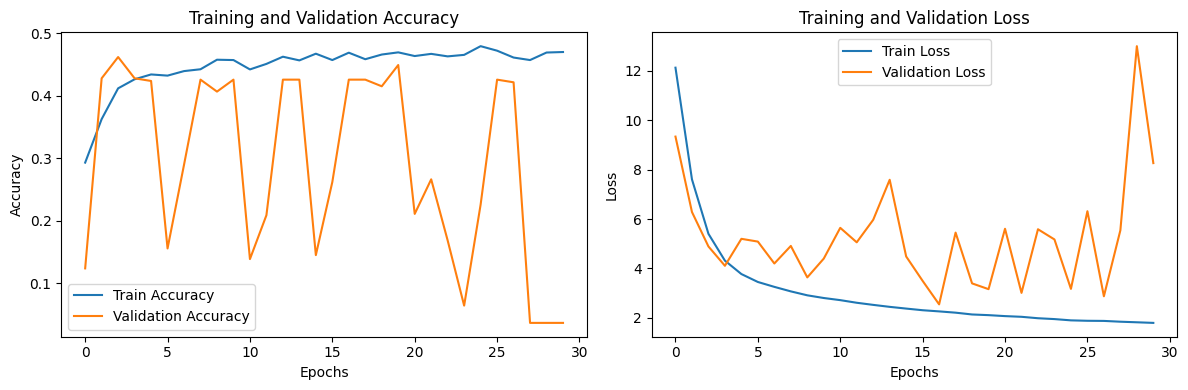

==== Comparação de Acurácia ====
SVM Binary Classifier Accuracy: 0.7148936170212766
SVM Multiclass Classifier Accuracy: 0.5468085106382978
ResNet50 Classifier Accuracy: 0.28936170212765955

==== Matrizes de Confusão ====
SVM Binary Classifier Confusion Matrix:
[[154  46]
 [ 88 182]]

SVM Multiclass Classifier Confusion Matrix:
[[  6   4   4   1   2   0]
 [  7  18   6  10  38   0]
 [  0   6  33   7   6   6]
 [  2   6   9  23  56   3]
 [  0  12   3  10 175   0]
 [  0   5   6   2   2   2]]

ResNet50 Classifier Confusion Matrix:
[[  0   1   4  12  15   2]
 [  2  17  13  38  84   4]
 [  3  12  12  30  55   4]
 [  1  14  27  45 100  11]
 [  4  33  66  86 198  13]
 [  0   1   4  11  18   0]]

==== Relatórios de Classificação ====
SVM Binary Classifier Classification Report:
              precision    recall  f1-score   support

    Negative       0.64      0.77      0.70       200
      Others       0.80      0.67      0.73       270

    accuracy                           0.71       470
   m

<ipython-input-18-ce72cdef4013>:56: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


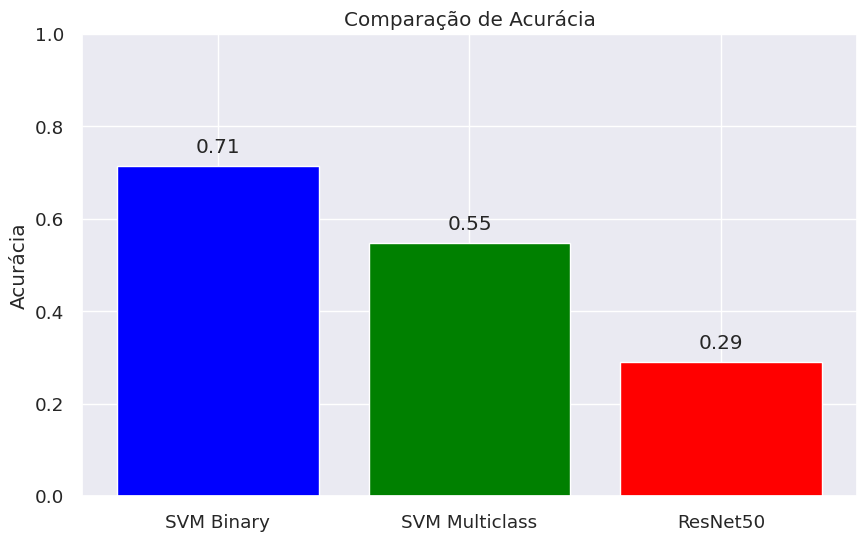

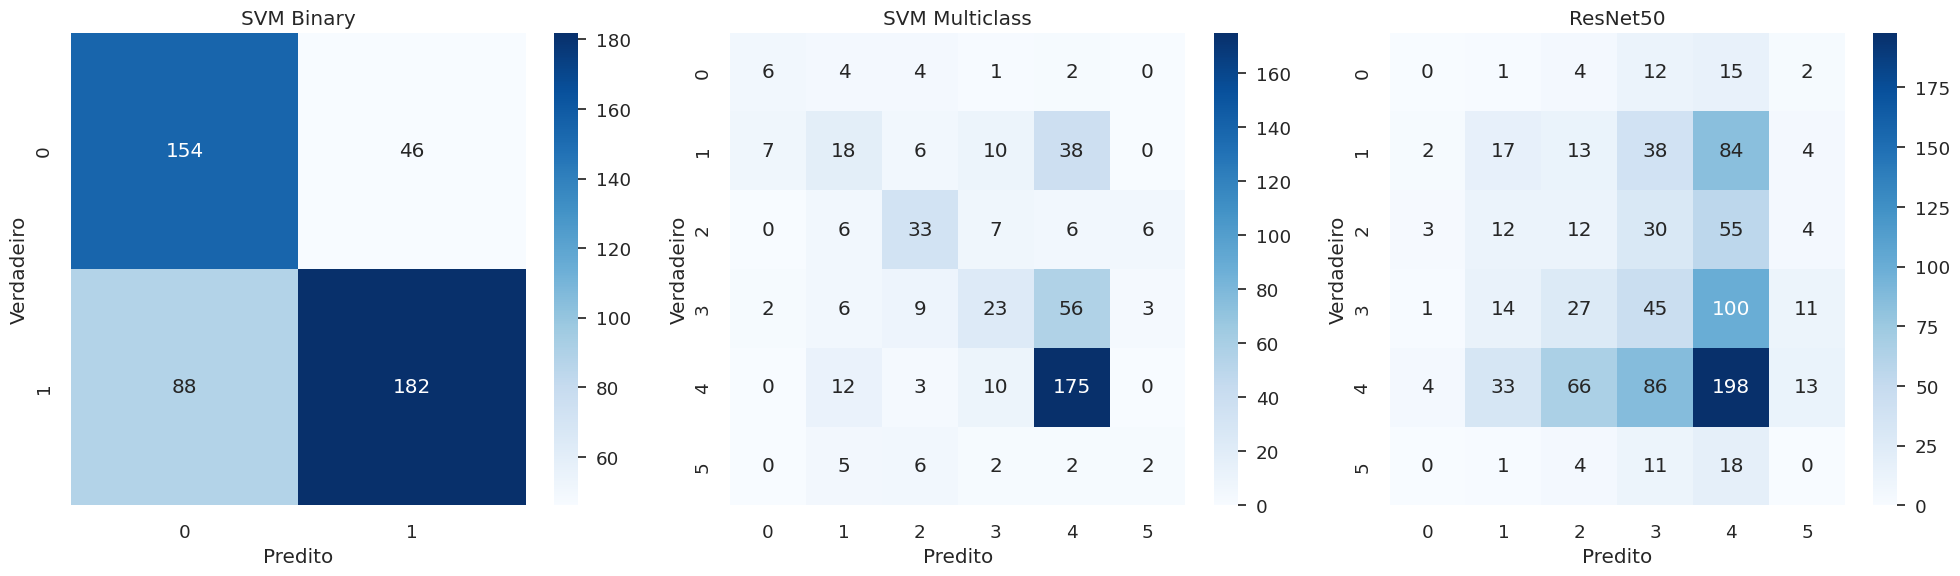

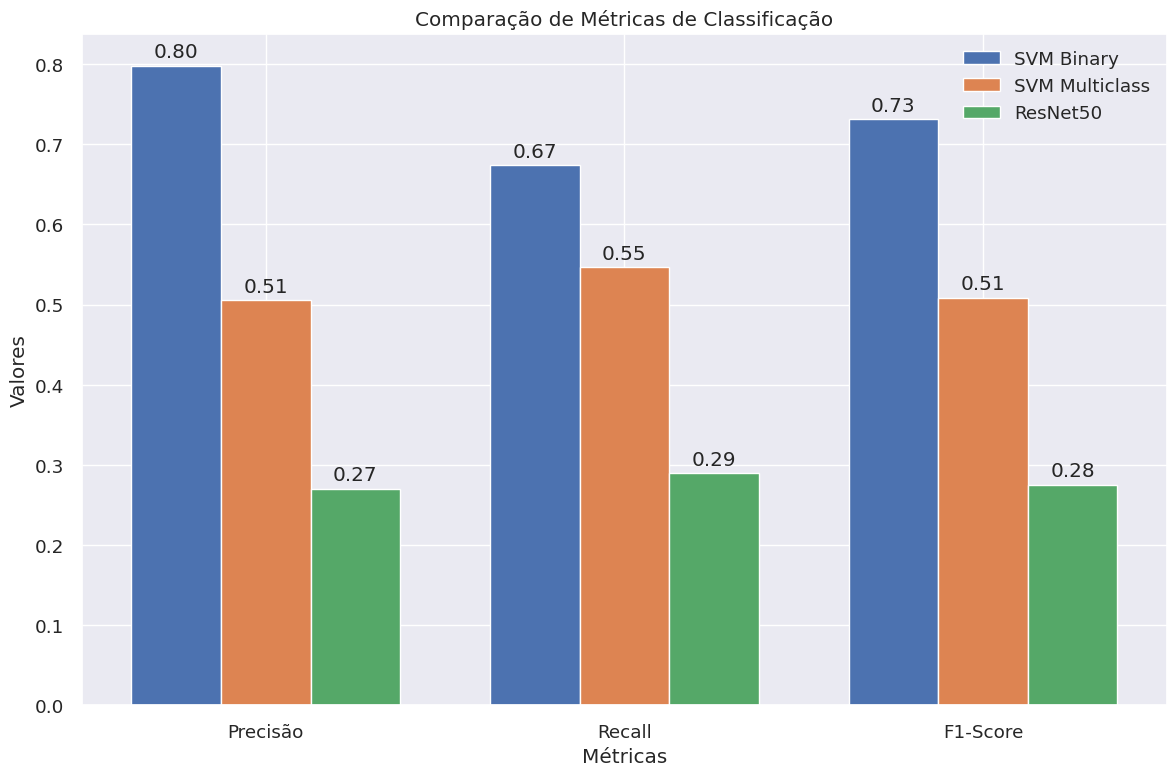

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

# Função para plotar gráfico de aprendizado
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotar curvas de aprendizado
plot_learning_curves(history)

# Comparação de Acurácia
print("==== Comparação de Acurácia ====")
print(f'SVM Binary Classifier Accuracy: {binary_accuracy}')
print(f'SVM Multiclass Classifier Accuracy: {multiclass_accuracy}')
print(f'ResNet50 Classifier Accuracy: {accuracy}')

# Comparação de Matrizes de Confusão
print("\n==== Matrizes de Confusão ====")
print("SVM Binary Classifier Confusion Matrix:")
print(binary_conf_matrix)
print("\nSVM Multiclass Classifier Confusion Matrix:")
print(multiclass_conf_matrix)
print("\nResNet50 Classifier Confusion Matrix:")
print(conf_matrix)

# Comparação de Relatórios de Classificação
print("\n==== Relatórios de Classificação ====")
print("SVM Binary Classifier Classification Report:")
print(classification_report(binary_labels_test, binary_predictions, target_names=['Negative', 'Others']))
print("\nSVM Multiclass Classifier Classification Report:")
print(classification_report(test_labels_encoded, multiclass_predictions, target_names=label_encoder.classes_))
print("\nResNet50 Classifier Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Configurações gerais para os gráficos
plt.style.use('seaborn')
sns.set(font_scale=1.2)

# 1. Gráfico de Barras para Acurácia
accuracies = [binary_accuracy, multiclass_accuracy, accuracy]
models = ['SVM Binary', 'SVM Multiclass', 'ResNet50']

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom')
plt.show()

# 2. Heatmaps para Matrizes de Confusão
conf_matrices = [binary_conf_matrix, multiclass_conf_matrix, conf_matrix]
titles = ['SVM Binary', 'SVM Multiclass', 'ResNet50']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for ax, conf_matrix, title in zip(axes, conf_matrices, titles):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predito')
    ax.set_ylabel('Verdadeiro')
plt.tight_layout()
plt.show()

# 3. Gráficos de Barras para Métricas de Classificação
# Métricas de classificação: precisão, recall, F1-score
binary_metrics = precision_recall_fscore_support(binary_labels_test, binary_predictions, average='binary')[:3]
multiclass_metrics = precision_recall_fscore_support(test_labels_encoded, multiclass_predictions, average='weighted')[:3]
resnet_metrics = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')[:3]

metrics = ['Precisão', 'Recall', 'F1-Score']
binary_values = [binary_metrics[0], binary_metrics[1], binary_metrics[2]]
multiclass_values = [multiclass_metrics[0], multiclass_metrics[1], multiclass_metrics[2]]
resnet_values = [resnet_metrics[0], resnet_metrics[1], resnet_metrics[2]]

x = np.arange(len(metrics))  # localização dos rótulos
width = 0.25  # largura das barras

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width, binary_values, width, label='SVM Binary')
rects2 = ax.bar(x, multiclass_values, width, label='SVM Multiclass')
rects3 = ax.bar(x + width, resnet_values, width, label='ResNet50')

# Adicionar texto para os rótulos
ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparação de Métricas de Classificação')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

def autolabel(rects):
    """Anexa um rótulo de texto acima de cada barra, exibindo seu valor."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 pontos de deslocamento vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

In [19]:
# Etapa 2 - Número 4: Comparação de Resultados:


#Rede Neural (1.000 imagens de cada classe):
# Found 2037 images belonging to 6 classes.
# Found 805 images belonging to 6 classes.
# Found 797 images belonging to 6 classes.
# Epoch 1/30
# 64/64 [==============================] - 16s 184ms/step - loss: 13.5700 - accuracy: 0.2641 - val_loss: 12.0976 - val_accuracy: 0.0509
# Epoch 2/30
# 64/64 [==============================] - 9s 148ms/step - loss: 10.2440 - accuracy: 0.3211 - val_loss: 9.1001 - val_accuracy: 0.1938
# Epoch 3/30
# 64/64 [==============================] - 9s 137ms/step - loss: 8.0299 - accuracy: 0.3397 - val_loss: 7.2859 - val_accuracy: 0.2075
# Epoch 4/30
# 64/64 [==============================] - 9s 133ms/step - loss: 6.5430 - accuracy: 0.3579 - val_loss: 6.0852 - val_accuracy: 0.3143
# Epoch 5/30
# 64/64 [==============================] - 9s 148ms/step - loss: 5.5302 - accuracy: 0.3760 - val_loss: 5.9909 - val_accuracy: 0.3143
# Epoch 6/30
# 64/64 [==============================] - 9s 146ms/step - loss: 4.8359 - accuracy: 0.3864 - val_loss: 5.0607 - val_accuracy: 0.3143
# Epoch 7/30
# 64/64 [==============================] - 10s 156ms/step - loss: 4.3658 - accuracy: 0.3991 - val_loss: 7.0809 - val_accuracy: 0.0447
# Epoch 8/30
# 64/64 [==============================] - 9s 145ms/step - loss: 4.0533 - accuracy: 0.3962 - val_loss: 5.0719 - val_accuracy: 0.3143
# Epoch 9/30
# 64/64 [==============================] - 10s 149ms/step - loss: 3.7930 - accuracy: 0.4089 - val_loss: 4.1247 - val_accuracy: 0.2509
# Epoch 10/30
# 64/64 [==============================] - 10s 153ms/step - loss: 3.5963 - accuracy: 0.4134 - val_loss: 5.6467 - val_accuracy: 0.3143
# Epoch 11/30
# 64/64 [==============================] - 10s 161ms/step - loss: 3.5038 - accuracy: 0.4006 - val_loss: 5.5816 - val_accuracy: 0.3155
# Epoch 12/30
# 64/64 [==============================] - 8s 133ms/step - loss: 3.3871 - accuracy: 0.4035 - val_loss: 4.5442 - val_accuracy: 0.2012
# Epoch 13/30
# 64/64 [==============================] - 10s 150ms/step - loss: 3.2483 - accuracy: 0.4055 - val_loss: 6.3419 - val_accuracy: 0.3193
# Epoch 14/30
# 64/64 [==============================] - 10s 150ms/step - loss: 3.1760 - accuracy: 0.4089 - val_loss: 10.3866 - val_accuracy: 0.3143
# Epoch 15/30
# 64/64 [==============================] - 9s 136ms/step - loss: 3.0852 - accuracy: 0.4129 - val_loss: 5.1842 - val_accuracy: 0.3143
# Epoch 16/30
# 64/64 [==============================] - 9s 137ms/step - loss: 3.0400 - accuracy: 0.4099 - val_loss: 3.9754 - val_accuracy: 0.2534
# Epoch 17/30
# 64/64 [==============================] - 10s 149ms/step - loss: 2.9687 - accuracy: 0.4148 - val_loss: 12.1024 - val_accuracy: 0.3143
# Epoch 18/30
# 64/64 [==============================] - 9s 146ms/step - loss: 2.9050 - accuracy: 0.4163 - val_loss: 5.5593 - val_accuracy: 0.0522
# Epoch 19/30
# 64/64 [==============================] - 9s 137ms/step - loss: 2.8096 - accuracy: 0.4119 - val_loss: 5.9457 - val_accuracy: 0.0559
# Epoch 20/30
# 64/64 [==============================] - 9s 133ms/step - loss: 2.7621 - accuracy: 0.4129 - val_loss: 5.1548 - val_accuracy: 0.2311
# Epoch 21/30
# 64/64 [==============================] - 9s 142ms/step - loss: 2.7199 - accuracy: 0.4246 - val_loss: 5.6391 - val_accuracy: 0.2161
# Epoch 22/30
# 64/64 [==============================] - 9s 148ms/step - loss: 2.6605 - accuracy: 0.4168 - val_loss: 5.0455 - val_accuracy: 0.3143
# Epoch 23/30
# 64/64 [==============================] - 10s 150ms/step - loss: 2.6190 - accuracy: 0.4207 - val_loss: 4.2873 - val_accuracy: 0.3180
# Epoch 24/30
# 64/64 [==============================] - 8s 130ms/step - loss: 2.5822 - accuracy: 0.4246 - val_loss: 7.6085 - val_accuracy: 0.3143
# Epoch 25/30
# 64/64 [==============================] - 9s 148ms/step - loss: 2.5455 - accuracy: 0.4227 - val_loss: 3.5279 - val_accuracy: 0.2224
# Epoch 26/30
# 64/64 [==============================] - 10s 149ms/step - loss: 2.4830 - accuracy: 0.4408 - val_loss: 6.4590 - val_accuracy: 0.0460
# Epoch 27/30
# 64/64 [==============================] - 9s 136ms/step - loss: 2.4667 - accuracy: 0.4286 - val_loss: 5.8520 - val_accuracy: 0.1267
# Epoch 28/30
# 64/64 [==============================] - 9s 142ms/step - loss: 2.4167 - accuracy: 0.4345 - val_loss: 7.1344 - val_accuracy: 0.3143
# Epoch 29/30
# 64/64 [==============================] - 10s 154ms/step - loss: 2.3761 - accuracy: 0.4256 - val_loss: 5.6150 - val_accuracy: 0.1180
# Epoch 30/30
# 64/64 [==============================] - 11s 166ms/step - loss: 2.3646 - accuracy: 0.4340 - val_loss: 3.6267 - val_accuracy: 0.2298
# Epoch 1/20
# 64/64 [==============================] - 45s 206ms/step - loss: 2.9549 - accuracy: 0.3584 - val_loss: 2.8622 - val_accuracy: 0.3056
# Epoch 2/20
# 64/64 [==============================] - 11s 171ms/step - loss: 2.6053 - accuracy: 0.4423 - val_loss: 3.1694 - val_accuracy: 0.3143
# Epoch 3/20
# 64/64 [==============================] - 12s 184ms/step - loss: 2.5010 - accuracy: 0.4458 - val_loss: 4.9082 - val_accuracy: 0.3056
# Epoch 4/20
# 64/64 [==============================] - 10s 162ms/step - loss: 2.3888 - accuracy: 0.4826 - val_loss: 5.1419 - val_accuracy: 0.3093
# Epoch 5/20
# 64/64 [==============================] - 11s 164ms/step - loss: 2.3569 - accuracy: 0.4752 - val_loss: 6.0688 - val_accuracy: 0.3143
# Epoch 6/20
# 64/64 [==============================] - 11s 176ms/step - loss: 2.3143 - accuracy: 0.4909 - val_loss: 4.9855 - val_accuracy: 0.3193
# Epoch 7/20
# 64/64 [==============================] - 11s 177ms/step - loss: 2.2714 - accuracy: 0.5169 - val_loss: 3.4353 - val_accuracy: 0.2124
# Epoch 8/20
# 64/64 [==============================] - 10s 159ms/step - loss: 2.2721 - accuracy: 0.5115 - val_loss: 2.7955 - val_accuracy: 0.2894
# Epoch 9/20
# 64/64 [==============================] - 11s 173ms/step - loss: 2.2038 - accuracy: 0.5204 - val_loss: 2.9421 - val_accuracy: 0.2770
# Epoch 10/20
# 64/64 [==============================] - 11s 175ms/step - loss: 2.2160 - accuracy: 0.5307 - val_loss: 3.0551 - val_accuracy: 0.2596
# Epoch 11/20
# 64/64 [==============================] - 11s 164ms/step - loss: 2.1450 - accuracy: 0.5479 - val_loss: 3.1095 - val_accuracy: 0.2658
# Epoch 12/20
# 64/64 [==============================] - 10s 156ms/step - loss: 2.1215 - accuracy: 0.5503 - val_loss: 3.1971 - val_accuracy: 0.2683
# Epoch 13/20
# 64/64 [==============================] - 11s 175ms/step - loss: 2.0969 - accuracy: 0.5434 - val_loss: 3.0300 - val_accuracy: 0.2708
# Epoch 14/20
# 64/64 [==============================] - 12s 193ms/step - loss: 2.1205 - accuracy: 0.5557 - val_loss: 2.7476 - val_accuracy: 0.3205
# Epoch 15/20
# 64/64 [==============================] - 11s 175ms/step - loss: 2.0457 - accuracy: 0.5660 - val_loss: 2.4871 - val_accuracy: 0.3739
# Epoch 16/20
# 64/64 [==============================] - 11s 170ms/step - loss: 2.0847 - accuracy: 0.5596 - val_loss: 2.2797 - val_accuracy: 0.4460
# Epoch 17/20
# 64/64 [==============================] - 11s 178ms/step - loss: 2.0516 - accuracy: 0.5680 - val_loss: 2.0958 - val_accuracy: 0.5056
# Epoch 18/20
# 64/64 [==============================] - 12s 186ms/step - loss: 2.0212 - accuracy: 0.5812 - val_loss: 1.9185 - val_accuracy: 0.5652
# Epoch 19/20
# 64/64 [==============================] - 11s 173ms/step - loss: 2.0133 - accuracy: 0.5665 - val_loss: 1.9558 - val_accuracy: 0.5801
# Epoch 20/20
# 64/64 [==============================] - 11s 173ms/step - loss: 1.9954 - accuracy: 0.5650 - val_loss: 1.9267 - val_accuracy: 0.5975
# 25/25 [==============================] - 2s 78ms/step - loss: 1.9346 - accuracy: 0.6123
# Test accuracy: 0.6122961044311523


# Etapa 2 - Número 1 (1.000 imagens de cada classe):
# Found 3904 images belonging to 6 classes.
# Found 805 images belonging to 6 classes.
# Found 1268 images belonging to 6 classes.
# Epoch 1/30
# 122/122 [==============================] - 21s 144ms/step - loss: 12.0839 - accuracy: 0.2941 - val_loss: 9.3830 - val_accuracy: 0.1714
# Epoch 2/30
# 122/122 [==============================] - 17s 136ms/step - loss: 7.5149 - accuracy: 0.3571 - val_loss: 6.1398 - val_accuracy: 0.3143
# Epoch 3/30
# 122/122 [==============================] - 17s 140ms/step - loss: 5.3520 - accuracy: 0.4006 - val_loss: 5.0149 - val_accuracy: 0.2199
# Epoch 4/30
# 122/122 [==============================] - 17s 135ms/step - loss: 4.3241 - accuracy: 0.4050 - val_loss: 4.4759 - val_accuracy: 0.3143
# Epoch 5/30
# 122/122 [==============================] - 17s 135ms/step - loss: 3.8401 - accuracy: 0.4101 - val_loss: 7.2752 - val_accuracy: 0.3143
# Epoch 6/30
# 122/122 [==============================] - 16s 135ms/step - loss: 3.5082 - accuracy: 0.4209 - val_loss: 6.3362 - val_accuracy: 0.1093
# Epoch 7/30
# 122/122 [==============================] - 17s 139ms/step - loss: 3.2837 - accuracy: 0.4280 - val_loss: 5.8864 - val_accuracy: 0.3950
# Epoch 8/30
# 122/122 [==============================] - 17s 140ms/step - loss: 3.1402 - accuracy: 0.4232 - val_loss: 3.4573 - val_accuracy: 0.3950
# Epoch 9/30
# 122/122 [==============================] - 16s 132ms/step - loss: 2.9992 - accuracy: 0.4273 - val_loss: 6.4796 - val_accuracy: 0.3193
# Epoch 10/30
# 122/122 [==============================] - 16s 134ms/step - loss: 2.8626 - accuracy: 0.4288 - val_loss: 4.5881 - val_accuracy: 0.3205
# Epoch 11/30
# 122/122 [==============================] - 19s 155ms/step - loss: 2.7610 - accuracy: 0.4331 - val_loss: 5.1245 - val_accuracy: 0.3267
# Epoch 12/30
# 122/122 [==============================] - 16s 134ms/step - loss: 2.6637 - accuracy: 0.4378 - val_loss: 4.2395 - val_accuracy: 0.2261
# Epoch 13/30
# 122/122 [==============================] - 17s 142ms/step - loss: 2.5767 - accuracy: 0.4321 - val_loss: 3.5131 - val_accuracy: 0.3130
# Epoch 14/30
# 122/122 [==============================] - 16s 131ms/step - loss: 2.4916 - accuracy: 0.4342 - val_loss: 7.7618 - val_accuracy: 0.1702
# Epoch 15/30
# 122/122 [==============================] - 16s 133ms/step - loss: 2.4260 - accuracy: 0.4429 - val_loss: 3.7722 - val_accuracy: 0.2149
# Epoch 16/30
# 122/122 [==============================] - 16s 133ms/step - loss: 2.3653 - accuracy: 0.4334 - val_loss: 5.2043 - val_accuracy: 0.3155
# Epoch 17/30
# 122/122 [==============================] - 18s 145ms/step - loss: 2.2969 - accuracy: 0.4434 - val_loss: 4.7315 - val_accuracy: 0.3217
# Epoch 18/30
# 122/122 [==============================] - 16s 133ms/step - loss: 2.2326 - accuracy: 0.4511 - val_loss: 3.5455 - val_accuracy: 0.1764
# Epoch 19/30
# 122/122 [==============================] - 16s 132ms/step - loss: 2.2102 - accuracy: 0.4449 - val_loss: 7.9723 - val_accuracy: 0.2137
# Epoch 20/30
# 122/122 [==============================] - 17s 141ms/step - loss: 2.1599 - accuracy: 0.4483 - val_loss: 5.0537 - val_accuracy: 0.4149
# Epoch 21/30
# 122/122 [==============================] - 17s 137ms/step - loss: 2.1045 - accuracy: 0.4518 - val_loss: 4.4915 - val_accuracy: 0.2323
# Epoch 22/30
# 122/122 [==============================] - 16s 134ms/step - loss: 2.0625 - accuracy: 0.4554 - val_loss: 6.7972 - val_accuracy: 0.0460
# Epoch 23/30
# 122/122 [==============================] - 17s 141ms/step - loss: 2.0292 - accuracy: 0.4477 - val_loss: 6.6514 - val_accuracy: 0.3143
# Epoch 24/30
# 122/122 [==============================] - 16s 134ms/step - loss: 1.9780 - accuracy: 0.4570 - val_loss: 2.9032 - val_accuracy: 0.2261
# Epoch 25/30
# 122/122 [==============================] - 16s 129ms/step - loss: 1.9472 - accuracy: 0.4460 - val_loss: 7.4044 - val_accuracy: 0.3143
# Epoch 26/30
# 122/122 [==============================] - 16s 131ms/step - loss: 1.9200 - accuracy: 0.4565 - val_loss: 9.5450 - val_accuracy: 0.0509
# Epoch 27/30
# 122/122 [==============================] - 17s 136ms/step - loss: 1.9004 - accuracy: 0.4580 - val_loss: 3.4936 - val_accuracy: 0.0472
# Epoch 28/30
# 122/122 [==============================] - 18s 150ms/step - loss: 1.8807 - accuracy: 0.4549 - val_loss: 5.0620 - val_accuracy: 0.0658
# Epoch 29/30
# 122/122 [==============================] - 16s 131ms/step - loss: 1.8398 - accuracy: 0.4506 - val_loss: 3.3794 - val_accuracy: 0.2137
# Epoch 30/30
# 122/122 [==============================] - 16s 133ms/step - loss: 1.8621 - accuracy: 0.4539 - val_loss: 4.0561 - val_accuracy: 0.2870
# Epoch 1/20
# 122/122 [==============================] - 49s 169ms/step - loss: 2.5873 - accuracy: 0.4080 - val_loss: 5.6910 - val_accuracy: 0.3143
# Epoch 2/20
# 122/122 [==============================] - 20s 160ms/step - loss: 2.0503 - accuracy: 0.4785 - val_loss: 7.8462 - val_accuracy: 0.3143
# Epoch 3/20
# 122/122 [==============================] - 20s 164ms/step - loss: 1.8663 - accuracy: 0.5138 - val_loss: 5.8711 - val_accuracy: 0.3143
# Epoch 4/20
# 122/122 [==============================] - 20s 163ms/step - loss: 1.7818 - accuracy: 0.5318 - val_loss: 3.2597 - val_accuracy: 0.3342
# Epoch 5/20
# 122/122 [==============================] - 19s 155ms/step - loss: 1.7099 - accuracy: 0.5346 - val_loss: 2.7576 - val_accuracy: 0.2522
# Epoch 6/20
# 122/122 [==============================] - 20s 163ms/step - loss: 1.6538 - accuracy: 0.5497 - val_loss: 2.6842 - val_accuracy: 0.1776
# Epoch 7/20
# 122/122 [==============================] - 19s 156ms/step - loss: 1.6599 - accuracy: 0.5499 - val_loss: 2.2557 - val_accuracy: 0.2882
# Epoch 8/20
# 122/122 [==============================] - 19s 157ms/step - loss: 1.5920 - accuracy: 0.5666 - val_loss: 1.7752 - val_accuracy: 0.4211
# Epoch 9/20
# 122/122 [==============================] - 21s 169ms/step - loss: 1.5775 - accuracy: 0.5725 - val_loss: 1.5623 - val_accuracy: 0.5068
# Epoch 10/20
# 122/122 [==============================] - 19s 158ms/step - loss: 1.5345 - accuracy: 0.5830 - val_loss: 1.4647 - val_accuracy: 0.5752
# Epoch 11/20
# 122/122 [==============================] - 20s 164ms/step - loss: 1.5447 - accuracy: 0.5886 - val_loss: 1.4210 - val_accuracy: 0.5876
# Epoch 12/20
# 122/122 [==============================] - 19s 156ms/step - loss: 1.5039 - accuracy: 0.6030 - val_loss: 1.3652 - val_accuracy: 0.6174
# Epoch 13/20
# 122/122 [==============================] - 21s 169ms/step - loss: 1.4665 - accuracy: 0.6091 - val_loss: 1.3497 - val_accuracy: 0.6137
# Epoch 14/20
# 122/122 [==============================] - 20s 165ms/step - loss: 1.4571 - accuracy: 0.6127 - val_loss: 1.3551 - val_accuracy: 0.6286
# Epoch 15/20
# 122/122 [==============================] - 20s 164ms/step - loss: 1.4305 - accuracy: 0.6212 - val_loss: 1.3090 - val_accuracy: 0.6584
# Epoch 16/20
# 122/122 [==============================] - 19s 158ms/step - loss: 1.4255 - accuracy: 0.6250 - val_loss: 1.3365 - val_accuracy: 0.6360
# Epoch 17/20
# 122/122 [==============================] - 20s 165ms/step - loss: 1.3856 - accuracy: 0.6342 - val_loss: 1.3487 - val_accuracy: 0.6273
# Epoch 18/20
# 122/122 [==============================] - 19s 157ms/step - loss: 1.3432 - accuracy: 0.6481 - val_loss: 1.2910 - val_accuracy: 0.6658
# Epoch 19/20
# 122/122 [==============================] - 20s 162ms/step - loss: 1.3627 - accuracy: 0.6409 - val_loss: 1.2352 - val_accuracy: 0.6770
# Epoch 20/20
# 122/122 [==============================] - 20s 160ms/step - loss: 1.3424 - accuracy: 0.6506 - val_loss: 1.2339 - val_accuracy: 0.6584
# 40/40 [==============================] - 3s 68ms/step - loss: 1.2548 - accuracy: 0.6696
# Test accuracy: 0.6695583462715149


# Etapa 2 - Número 2 - Classificador binário (SVM) (1.000 imagens de cada classe):
# Binary Classifier Accuracy: 0.7148936170212766
# Binary Classifier Confusion Matrix:
# [[154  46]
#  [ 88 182]]
# Binary Classifier Classification Report:
#               precision    recall  f1-score   support

#     Negative       0.64      0.77      0.70       200
#       Others       0.80      0.67      0.73       270

#     accuracy                           0.71       470
#    macro avg       0.72      0.72      0.71       470
# weighted avg       0.73      0.71      0.72       470

# Multiclass Classifier Accuracy: 0.5468085106382978
# Multiclass Classifier Confusion Matrix:
# [[  6   4   4   1   2   0]
#  [  7  18   6  10  38   0]
#  [  0   6  33   7   6   6]
#  [  2   6   9  23  56   3]
#  [  0  12   3  10 175   0]
#  [  0   5   6   2   2   2]]
# Multiclass Classifier Classification Report:
#                                      precision    recall  f1-score   support

#                               ASC-H       0.40      0.35      0.38        17
#                              ASC-US       0.35      0.23      0.28        79
#                                HSIL       0.54      0.57      0.55        58
#                                LSIL       0.43      0.23      0.30        99
# Negative for intraepithelial lesion       0.63      0.88      0.73       200
#                                 SCC       0.18      0.12      0.14        17

#                            accuracy                           0.55       470
#                           macro avg       0.42      0.40      0.40       470
#                        weighted avg       0.51      0.55      0.51       470


# Etapa 2 - Número 3 - ResNet50 (1.000 imagens de cada classe):
# Found 4145 images belonging to 6 classes.
# Found 1576 images belonging to 6 classes.
# Found 1576 images belonging to 6 classes.
# Epoch 1/30
# 130/130 [==============================] - 35s 200ms/step - loss: 11.9500 - accuracy: 0.2835 - val_loss: 9.1337 - val_accuracy: 0.2303
# Epoch 2/30
# 130/130 [==============================] - 19s 144ms/step - loss: 7.3541 - accuracy: 0.3706 - val_loss: 6.1016 - val_accuracy: 0.1491
# Epoch 3/30
# 130/130 [==============================] - 18s 141ms/step - loss: 5.2632 - accuracy: 0.4084 - val_loss: 4.7431 - val_accuracy: 0.2963
# Epoch 4/30
# 130/130 [==============================] - 19s 145ms/step - loss: 4.2616 - accuracy: 0.4287 - val_loss: 5.1295 - val_accuracy: 0.1478
# Epoch 5/30
# 130/130 [==============================] - 18s 139ms/step - loss: 3.7936 - accuracy: 0.4304 - val_loss: 6.1081 - val_accuracy: 0.3845
# Epoch 6/30
# 130/130 [==============================] - 19s 143ms/step - loss: 3.4947 - accuracy: 0.4413 - val_loss: 4.5566 - val_accuracy: 0.2145
# Epoch 7/30
# 130/130 [==============================] - 18s 136ms/step - loss: 3.2753 - accuracy: 0.4458 - val_loss: 5.2500 - val_accuracy: 0.1428
# Epoch 8/30
# 130/130 [==============================] - 18s 135ms/step - loss: 3.1098 - accuracy: 0.4427 - val_loss: 6.9868 - val_accuracy: 0.3813
# Epoch 9/30
# 130/130 [==============================] - 18s 136ms/step - loss: 2.9438 - accuracy: 0.4509 - val_loss: 3.8887 - val_accuracy: 0.1904
# Epoch 10/30
# 130/130 [==============================] - 17s 134ms/step - loss: 2.8494 - accuracy: 0.4439 - val_loss: 4.7657 - val_accuracy: 0.3813
# Epoch 11/30
# 130/130 [==============================] - 21s 159ms/step - loss: 2.7142 - accuracy: 0.4326 - val_loss: 3.5439 - val_accuracy: 0.3331
# Epoch 12/30
# 130/130 [==============================] - 19s 144ms/step - loss: 2.6046 - accuracy: 0.4524 - val_loss: 6.2786 - val_accuracy: 0.3807
# Epoch 13/30
# 130/130 [==============================] - 18s 137ms/step - loss: 2.5040 - accuracy: 0.4552 - val_loss: 3.6319 - val_accuracy: 0.0939
# Epoch 14/30
# 130/130 [==============================] - 18s 142ms/step - loss: 2.4401 - accuracy: 0.4610 - val_loss: 5.9719 - val_accuracy: 0.2519
# Epoch 15/30
# 130/130 [==============================] - 18s 140ms/step - loss: 2.3639 - accuracy: 0.4632 - val_loss: 3.6738 - val_accuracy: 0.2164
# Epoch 16/30
# 130/130 [==============================] - 19s 142ms/step - loss: 2.2913 - accuracy: 0.4606 - val_loss: 4.9068 - val_accuracy: 0.3997
# Epoch 17/30
# 130/130 [==============================] - 18s 137ms/step - loss: 2.2544 - accuracy: 0.4596 - val_loss: 3.8762 - val_accuracy: 0.3496
# Epoch 18/30
# 130/130 [==============================] - 18s 135ms/step - loss: 2.1906 - accuracy: 0.4627 - val_loss: 4.4613 - val_accuracy: 0.3991
# Epoch 19/30
# 130/130 [==============================] - 18s 137ms/step - loss: 2.1194 - accuracy: 0.4680 - val_loss: 2.6501 - val_accuracy: 0.2862
# Epoch 20/30
# 130/130 [==============================] - 20s 151ms/step - loss: 2.0866 - accuracy: 0.4639 - val_loss: 3.4020 - val_accuracy: 0.0742
# Epoch 21/30
# 130/130 [==============================] - 18s 141ms/step - loss: 2.0425 - accuracy: 0.4704 - val_loss: 3.4793 - val_accuracy: 0.1123
# Epoch 22/30
# 130/130 [==============================] - 18s 137ms/step - loss: 2.0108 - accuracy: 0.4565 - val_loss: 5.9076 - val_accuracy: 0.3807
# Epoch 23/30
# 130/130 [==============================] - 18s 139ms/step - loss: 1.9554 - accuracy: 0.4654 - val_loss: 6.6312 - val_accuracy: 0.3826
# Epoch 24/30
# 130/130 [==============================] - 18s 136ms/step - loss: 1.9489 - accuracy: 0.4579 - val_loss: 3.7480 - val_accuracy: 0.4086
# Epoch 25/30
# 130/130 [==============================] - 19s 144ms/step - loss: 1.8880 - accuracy: 0.4786 - val_loss: 2.2437 - val_accuracy: 0.4543
# Epoch 26/30
# 130/130 [==============================] - 18s 135ms/step - loss: 1.8660 - accuracy: 0.4743 - val_loss: 3.9568 - val_accuracy: 0.3813
# Epoch 27/30
# 130/130 [==============================] - 19s 144ms/step - loss: 1.8390 - accuracy: 0.4654 - val_loss: 3.1947 - val_accuracy: 0.4067
# Epoch 28/30
# 130/130 [==============================] - 18s 137ms/step - loss: 1.8315 - accuracy: 0.4683 - val_loss: 6.5164 - val_accuracy: 0.1745
# Epoch 29/30
# 130/130 [==============================] - 18s 136ms/step - loss: 1.8266 - accuracy: 0.4702 - val_loss: 8.5871 - val_accuracy: 0.2126
# Epoch 30/30
# 130/130 [==============================] - 19s 144ms/step - loss: 1.7967 - accuracy: 0.4608 - val_loss: 3.4350 - val_accuracy: 0.3991
# Epoch 1/20
# 130/130 [==============================] - 51s 167ms/step - loss: 2.4293 - accuracy: 0.4210 - val_loss: 2.7659 - val_accuracy: 0.1827
# Epoch 2/20
# 130/130 [==============================] - 21s 158ms/step - loss: 1.9259 - accuracy: 0.4977 - val_loss: 2.3338 - val_accuracy: 0.2881
# Epoch 3/20
# 130/130 [==============================] - 22s 165ms/step - loss: 1.7671 - accuracy: 0.5214 - val_loss: 2.3606 - val_accuracy: 0.3020
# Epoch 4/20
# 130/130 [==============================] - 21s 160ms/step - loss: 1.6811 - accuracy: 0.5472 - val_loss: 2.5838 - val_accuracy: 0.3668
# Epoch 5/20
# 130/130 [==============================] - 22s 166ms/step - loss: 1.6291 - accuracy: 0.5590 - val_loss: 2.4289 - val_accuracy: 0.3223
# Epoch 6/20
# 130/130 [==============================] - 22s 170ms/step - loss: 1.5747 - accuracy: 0.5638 - val_loss: 2.3817 - val_accuracy: 0.2874
# Epoch 7/20
# 130/130 [==============================] - 21s 163ms/step - loss: 1.5471 - accuracy: 0.5732 - val_loss: 1.9799 - val_accuracy: 0.3706
# Epoch 8/20
# 130/130 [==============================] - 22s 168ms/step - loss: 1.5071 - accuracy: 0.5870 - val_loss: 1.6081 - val_accuracy: 0.5222
# Epoch 9/20
# 130/130 [==============================] - 21s 158ms/step - loss: 1.4714 - accuracy: 0.6010 - val_loss: 1.4294 - val_accuracy: 0.5977
# Epoch 10/20
# 130/130 [==============================] - 22s 168ms/step - loss: 1.4642 - accuracy: 0.5971 - val_loss: 1.3858 - val_accuracy: 0.6358
# Epoch 11/20
# 130/130 [==============================] - 22s 168ms/step - loss: 1.4180 - accuracy: 0.6128 - val_loss: 1.3517 - val_accuracy: 0.6352
# Epoch 12/20
# 130/130 [==============================] - 21s 158ms/step - loss: 1.4135 - accuracy: 0.6171 - val_loss: 1.2900 - val_accuracy: 0.6497
# Epoch 13/20
# 130/130 [==============================] - 23s 179ms/step - loss: 1.3852 - accuracy: 0.6253 - val_loss: 1.2743 - val_accuracy: 0.6523
# Epoch 14/20
# 130/130 [==============================] - 22s 165ms/step - loss: 1.3307 - accuracy: 0.6367 - val_loss: 1.2572 - val_accuracy: 0.6650
# Epoch 15/20
# 130/130 [==============================] - 21s 159ms/step - loss: 1.3340 - accuracy: 0.6466 - val_loss: 1.2585 - val_accuracy: 0.6701
# Epoch 16/20
# 130/130 [==============================] - 22s 167ms/step - loss: 1.3133 - accuracy: 0.6439 - val_loss: 1.2733 - val_accuracy: 0.6434
# Epoch 17/20
# 130/130 [==============================] - 22s 167ms/step - loss: 1.3136 - accuracy: 0.6490 - val_loss: 1.2071 - val_accuracy: 0.6643
# Epoch 18/20
# 130/130 [==============================] - 22s 166ms/step - loss: 1.2663 - accuracy: 0.6673 - val_loss: 1.1992 - val_accuracy: 0.6770
# Epoch 19/20
# 130/130 [==============================] - 21s 158ms/step - loss: 1.2549 - accuracy: 0.6627 - val_loss: 1.1804 - val_accuracy: 0.6885
# Epoch 20/20
# 130/130 [==============================] - 23s 174ms/step - loss: 1.2269 - accuracy: 0.6625 - val_loss: 1.1562 - val_accuracy: 0.6872
# 50/50 [==============================] - 2s 36ms/step - loss: 1.1562 - accuracy: 0.6872
# /usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
#   saving_api.save_model(
# Test accuracy: 0.6871827244758606


# Etapa 2 - SVM e ResNet50 (1.000 imagens de cada classe):
# Found 4145 images belonging to 6 classes.
# Found 1576 images belonging to 6 classes.
# Found 1576 images belonging to 6 classes.
# Epoch 1/30
# 130/130 [==============================] - 23s 142ms/step - loss: 11.9079 - accuracy: 0.2989 - val_loss: 9.0935 - val_accuracy: 0.1459
# Epoch 2/30
# 130/130 [==============================] - 19s 145ms/step - loss: 7.3051 - accuracy: 0.3836 - val_loss: 6.3722 - val_accuracy: 0.2297
# Epoch 3/30
# 130/130 [==============================] - 17s 134ms/step - loss: 5.2021 - accuracy: 0.4068 - val_loss: 4.9892 - val_accuracy: 0.2056
# Epoch 4/30
# 130/130 [==============================] - 18s 137ms/step - loss: 4.2302 - accuracy: 0.4236 - val_loss: 6.7009 - val_accuracy: 0.2265
# Epoch 5/30
# 130/130 [==============================] - 23s 178ms/step - loss: 3.7406 - accuracy: 0.4304 - val_loss: 7.0771 - val_accuracy: 0.3807
# Epoch 6/30
# 130/130 [==============================] - 18s 137ms/step - loss: 3.4516 - accuracy: 0.4294 - val_loss: 7.7877 - val_accuracy: 0.2126
# Epoch 7/30
# 130/130 [==============================] - 19s 147ms/step - loss: 3.2179 - accuracy: 0.4454 - val_loss: 7.4186 - val_accuracy: 0.0451
# Epoch 8/30
# 130/130 [==============================] - 17s 134ms/step - loss: 3.0457 - accuracy: 0.4398 - val_loss: 3.8580 - val_accuracy: 0.3826
# Epoch 9/30
# 130/130 [==============================] - 19s 144ms/step - loss: 2.8947 - accuracy: 0.4495 - val_loss: 6.9476 - val_accuracy: 0.3807
# Epoch 10/30
# 130/130 [==============================] - 18s 136ms/step - loss: 2.7593 - accuracy: 0.4497 - val_loss: 4.1179 - val_accuracy: 0.2138
# Epoch 11/30
# 130/130 [==============================] - 19s 145ms/step - loss: 2.6538 - accuracy: 0.4490 - val_loss: 2.7631 - val_accuracy: 0.3236
# Epoch 12/30
# 130/130 [==============================] - 17s 134ms/step - loss: 2.5349 - accuracy: 0.4545 - val_loss: 5.2537 - val_accuracy: 0.3820
# Epoch 13/30
# 130/130 [==============================] - 19s 150ms/step - loss: 2.4710 - accuracy: 0.4533 - val_loss: 7.6483 - val_accuracy: 0.2157
# Epoch 14/30
# 130/130 [==============================] - 18s 140ms/step - loss: 2.4015 - accuracy: 0.4463 - val_loss: 4.0019 - val_accuracy: 0.4530
# Epoch 15/30
# 130/130 [==============================] - 18s 135ms/step - loss: 2.3336 - accuracy: 0.4555 - val_loss: 8.1283 - val_accuracy: 0.3807
# Epoch 16/30
# 130/130 [==============================] - 18s 138ms/step - loss: 2.2567 - accuracy: 0.4589 - val_loss: 5.3428 - val_accuracy: 0.1656
# Epoch 17/30
# 130/130 [==============================] - 18s 136ms/step - loss: 2.1925 - accuracy: 0.4579 - val_loss: 3.2652 - val_accuracy: 0.1510
# Epoch 18/30
# 130/130 [==============================] - 18s 137ms/step - loss: 2.1746 - accuracy: 0.4509 - val_loss: 2.4643 - val_accuracy: 0.4131
# Epoch 19/30
# 130/130 [==============================] - 18s 142ms/step - loss: 2.0951 - accuracy: 0.4620 - val_loss: 3.2564 - val_accuracy: 0.3522
# Epoch 20/30
# 130/130 [==============================] - 18s 137ms/step - loss: 2.0384 - accuracy: 0.4543 - val_loss: 6.2617 - val_accuracy: 0.0431
# Epoch 21/30
# 130/130 [==============================] - 19s 145ms/step - loss: 2.0075 - accuracy: 0.4613 - val_loss: 4.0656 - val_accuracy: 0.2145
# Epoch 22/30
# 130/130 [==============================] - 20s 153ms/step - loss: 1.9817 - accuracy: 0.4627 - val_loss: 4.0432 - val_accuracy: 0.2214
# Epoch 23/30
# 130/130 [==============================] - 18s 141ms/step - loss: 1.9392 - accuracy: 0.4663 - val_loss: 3.7619 - val_accuracy: 0.3839
# Epoch 24/30
# 130/130 [==============================] - 18s 138ms/step - loss: 1.9219 - accuracy: 0.4625 - val_loss: 2.4711 - val_accuracy: 0.2868
# Epoch 25/30
# 130/130 [==============================] - 18s 138ms/step - loss: 1.8769 - accuracy: 0.4760 - val_loss: 4.6195 - val_accuracy: 0.2728
# Epoch 26/30
# 130/130 [==============================] - 18s 136ms/step - loss: 1.8444 - accuracy: 0.4671 - val_loss: 7.6659 - val_accuracy: 0.3807
# Epoch 27/30
# 130/130 [==============================] - 18s 138ms/step - loss: 1.8222 - accuracy: 0.4642 - val_loss: 4.7431 - val_accuracy: 0.3852
# Epoch 28/30
# 130/130 [==============================] - 18s 139ms/step - loss: 1.8128 - accuracy: 0.4743 - val_loss: 9.1119 - val_accuracy: 0.0412
# Epoch 29/30
# 130/130 [==============================] - 19s 143ms/step - loss: 1.8173 - accuracy: 0.4610 - val_loss: 4.8592 - val_accuracy: 0.0495
# Epoch 30/30
# 130/130 [==============================] - 20s 153ms/step - loss: 1.7727 - accuracy: 0.4647 - val_loss: 4.0916 - val_accuracy: 0.2449
# Epoch 1/20
# 130/130 [==============================] - 52s 177ms/step - loss: 2.4640 - accuracy: 0.4248 - val_loss: 2.8330 - val_accuracy: 0.1783
# Epoch 2/20
# 130/130 [==============================] - 22s 166ms/step - loss: 1.8828 - accuracy: 0.5110 - val_loss: 3.5504 - val_accuracy: 0.1726
# Epoch 3/20
# 130/130 [==============================] - 21s 158ms/step - loss: 1.7654 - accuracy: 0.5310 - val_loss: 2.6772 - val_accuracy: 0.2513
# Epoch 4/20
# 130/130 [==============================] - 22s 169ms/step - loss: 1.6637 - accuracy: 0.5467 - val_loss: 2.4691 - val_accuracy: 0.2646
# Epoch 5/20
# 130/130 [==============================] - 22s 167ms/step - loss: 1.6037 - accuracy: 0.5616 - val_loss: 3.0168 - val_accuracy: 0.1523
# Epoch 6/20
# 130/130 [==============================] - 21s 159ms/step - loss: 1.5608 - accuracy: 0.5648 - val_loss: 2.6293 - val_accuracy: 0.2018
# Epoch 7/20
# 130/130 [==============================] - 22s 169ms/step - loss: 1.5164 - accuracy: 0.5780 - val_loss: 1.8684 - val_accuracy: 0.3693
# Epoch 8/20
# 130/130 [==============================] - 22s 167ms/step - loss: 1.4829 - accuracy: 0.6005 - val_loss: 1.5374 - val_accuracy: 0.5152
# Epoch 9/20
# 130/130 [==============================] - 22s 167ms/step - loss: 1.4486 - accuracy: 0.6012 - val_loss: 1.3931 - val_accuracy: 0.5996
# Epoch 10/20
# 130/130 [==============================] - 23s 178ms/step - loss: 1.4216 - accuracy: 0.6128 - val_loss: 1.3182 - val_accuracy: 0.6396
# Epoch 11/20
# 130/130 [==============================] - 21s 158ms/step - loss: 1.4097 - accuracy: 0.6183 - val_loss: 1.2821 - val_accuracy: 0.6491
# Epoch 12/20
# 130/130 [==============================] - 22s 170ms/step - loss: 1.3855 - accuracy: 0.6258 - val_loss: 1.2577 - val_accuracy: 0.6472
# Epoch 13/20
# 130/130 [==============================] - 21s 160ms/step - loss: 1.3601 - accuracy: 0.6258 - val_loss: 1.2483 - val_accuracy: 0.6580
# Epoch 14/20
# 130/130 [==============================] - 22s 166ms/step - loss: 1.3160 - accuracy: 0.6483 - val_loss: 1.2383 - val_accuracy: 0.6542
# Epoch 15/20
# 130/130 [==============================] - 22s 168ms/step - loss: 1.3217 - accuracy: 0.6422 - val_loss: 1.2049 - val_accuracy: 0.6624
# Epoch 16/20
# 130/130 [==============================] - 21s 163ms/step - loss: 1.3003 - accuracy: 0.6473 - val_loss: 1.2281 - val_accuracy: 0.6650
# Epoch 17/20
# 130/130 [==============================] - 23s 175ms/step - loss: 1.2724 - accuracy: 0.6514 - val_loss: 1.1866 - val_accuracy: 0.6758
# Epoch 18/20
# 130/130 [==============================] - 22s 168ms/step - loss: 1.2592 - accuracy: 0.6555 - val_loss: 1.2012 - val_accuracy: 0.6840
# Epoch 19/20
# 130/130 [==============================] - 21s 164ms/step - loss: 1.2431 - accuracy: 0.6591 - val_loss: 1.1415 - val_accuracy: 0.6929
# Epoch 20/20
# 130/130 [==============================] - 21s 163ms/step - loss: 1.2408 - accuracy: 0.6741 - val_loss: 1.1157 - val_accuracy: 0.6961
# 50/50 [==============================] - 2s 37ms/step - loss: 1.1157 - accuracy: 0.6961
# /usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
#   saving_api.save_model(
# Test accuracy: 0.6960659623146057